In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
#from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15
from datetime import datetime
from decimal import Decimal
from scipy import stats
from datetime import datetime
import subprocess
c = 299792458 #speed of light m s^-1
#plt.rcParams['figure.figsize'] = [20, 10]

import extinction

startTime = datetime.now()

from os.path import expanduser
home = expanduser("~")
libdir = home + '/sed_research'

In [2]:
from sedlib import read_params,sed

In [3]:
home

'/Users/cv'

In [4]:
parfile = libdir + '/params/nir.par'
tempfile = libdir + '/Templates/ARP220_loglam_lognuLnu.txt'

In [5]:
Av = 1.0
Rv = 5.0

#Initializing here, so we don't have to call the class every time

z = 1.5
mysed = sed(parfile,tempfile)

#######
mysed.extinction(Av=Av,Rv=Rv)

mysed.redshift(z)
mysed.photometry()
phot, phot_err, tag, eazytag = mysed.export_phot(program="EAZY")


In [6]:
folder = home + "/eazy-photoz/templates/vb/"
filename = "ARP220.dat"
mysed.export_template(filename,folder)

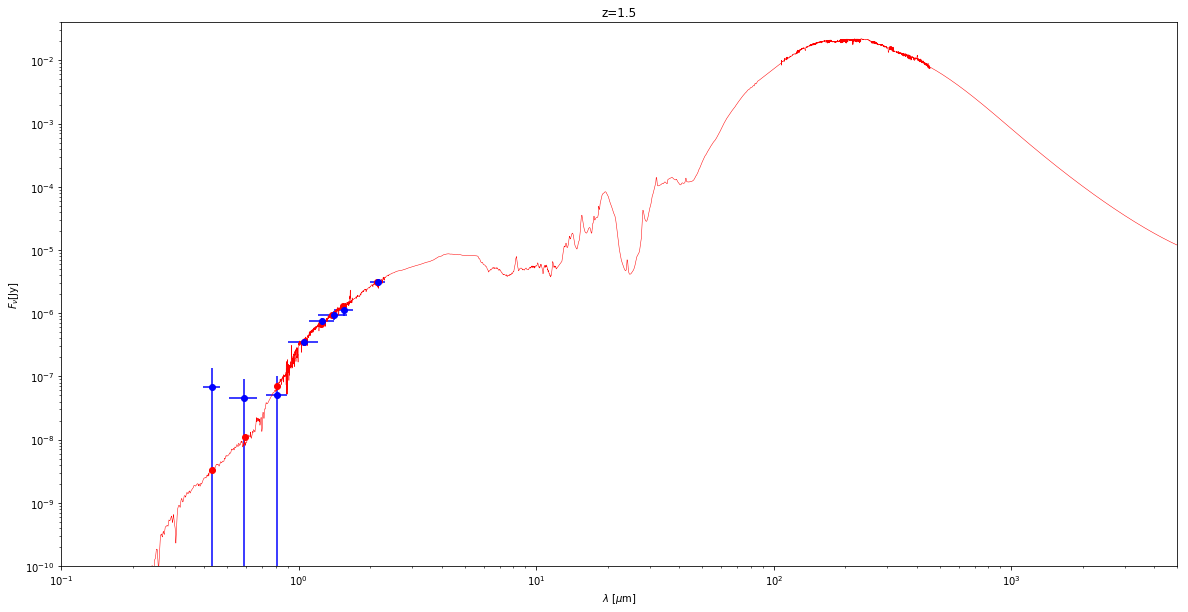

In [7]:
plt.rcParams['figure.figsize'] = [20, 10]

z = 1.5
mysed = sed(parfile,tempfile)
mysed.extinction(Av=Av,Rv=Rv)
mysed.redshift(z)
mysed.photometry()

ax = plt.subplot(111)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')

plt.errorbar(mysed.lam_c, mysed.phot, xerr=mysed.lam_err, yerr=mysed.phot_err,fmt="bo",ecolor="blue")
plt.plot(mysed.lam_eff, mysed.phot_c, "ro")
mysed.plot_sed(scale="normal",color="red")
#plt.plot(mysed.lam_eff,mysed.phot_c,"ro")

#test 
#plt.errorbar(lam_c,phot_test,yerr=phot_err_test,fmt="co")

#mysed.plot_filters(1e-8)
plt.ylim(1e-10,4e-2)
plt.xlim(1e-1,5e3)
#plt.legend(loc="lower right")

plt.show()
#plt.savefig("arp220Av{}Rv{}.png".format(Av,Rv),dpi=150)

In [8]:
mysed.lam_c

[2.146, 1.4, 1.05, 0.431, 0.589, 1.545, 0.811, 1.25]

In [9]:
idx = np.argsort(mysed.lam_c)

In [10]:
idx

array([3, 4, 6, 2, 7, 1, 5, 0])

In [11]:
np.asarray(mysed.tag)[idx]

array(['F435W', 'F606W', 'F814W', 'F105W', 'F125W', 'F140W', 'F160W',
       'Ks'], dtype='|S5')

In [12]:
np.array(mysed.det)[idx]

array(['up_lim', 'up_lim', 'up_lim', 'det', 'det', 'det', 'det', 'det'],
      dtype='|S6')

In [13]:
#Translation from name to filters on EAZY FILTER.RES
eazyfolder = home + "/eazy-photoz"
with open(eazyfolder + "/inputs/zphot.translate","w") as f:
    for i in range(len(eazytag)):
        f.write("f_{} F{}\n".format(str(tag[i]),str(int(eazytag[i]))))
        f.write("e_{} E{}\n".format(str(tag[i]),str(int(eazytag[i]))))

In [14]:
#Creating a Mock catalog
zspace = np.linspace(1.,4.0,10000) #Redshift grid

In [15]:
with open(home + "/eazy-photoz/inputs/eazy.cat","w") as f:
    L = "#id"
    for i in range(len(tag)):
        L+= " f_{} e_{}".format(tag[i],tag[i])
#    f.write(L + " z_spec" + "\n")
    f.write(L + "\n")
    L = "#id"
    for i in range(len(eazytag)):
        L+= " F{} E{}".format(np.int(eazytag[i]),np.int(eazytag[i]))
#    f.write(L + " z_spec" + "\n")
    f.write(L + "\n")
    #######
    for i in range(len(zspace)):
        mysed.redshift(zspace[i])
        mysed.photometry()
        phot, phot_err, tag, eazytag = mysed.export_phot(program="EAZY")
        L = "{}".format(i+1)
        for j in range(len(phot)):
            #EAZY format for Flux is microJansky
            L += "  " + "{:.5e}".format(Decimal(str(1e6*phot[j]))) + "  " + "{:.5e}".format(Decimal(str(1e6*phot_err[j])))
#        L+= " -1.0000"
        L+= "\n"
        f.write(L)
    print "done"

done


In [16]:
#Running EAZY from here
os.chdir(home + "/eazy-photoz/inputs/")
subprocess.call("../src/eazy -p zphot.param.default",shell=True)

0

In [17]:
zout = np.loadtxt(home + "/eazy-photoz/inputs/OUTPUT/photz.zout",comments="#",usecols=(14),unpack=True)

In [18]:
zout

array([  1.5155,   1.5183,   1.5428, ..., -99.    , -99.    , -99.    ])

In [19]:
zspace[1000]

1.3000300030003

In [20]:

mask = zout>0
zout_m = zout[mask]
zspace_m = zspace[mask]

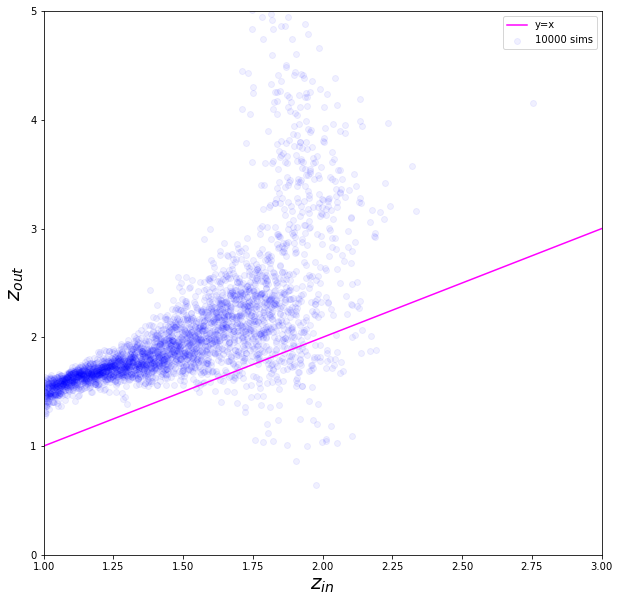

In [21]:
plt.rcParams['figure.figsize'] = [10, 10]


#slope, intercept, r_value, p_value, std_err = stats.linregress(zspace_m[:300],zout_m[:300])
x = np.linspace(1.,4.0,10000)
#y = slope*x+intercept
#plt.plot(x,y,color="red",label="linear_regress: slope = {}, intercept = {}".format(slope,intercept))
#print slope,intercept

plt.plot(x,x,color="magenta",label="y=x")

plt.xlabel(r"$z_{in}$",fontsize=20)
plt.ylabel(r"$z_{out}$",fontsize=20)

plt.xlim(1.,3.0)
plt.ylim(0.,5.0)

plt.scatter(zspace,zout,c="blue",alpha=0.06,label="10000 sims")
plt.legend()

plt.show()
#plt.savefig("arp220Av{}Rv{}.png".format(Av,Rv),dpi=150)

In [22]:
bins = np.linspace(1.,2.,10)
digitized = np.digitize(zspace_m,bins)
data = zout_m-zspace_m

hb = []
for i in range(len(bins)-1):
    hb.append((bins[i]+bins[i+1])/2.)
hb = np.asarray(hb)

means = [np.median(data[digitized == i]) for i in range(1, len(bins))]
std = [data[digitized == i].std() for i in range(1, len(bins))]



In [23]:
means

[0.5086899489948995,
 0.5004845634563456,
 0.46501902190219024,
 0.41616651665166504,
 0.44670211521152114,
 0.49369011401140106,
 0.5170324332433243,
 0.5436187518751874,
 0.7268544254425443]

In [24]:
std

[0.06435706999135153,
 0.06466768268608288,
 0.0888826775087754,
 0.13464381029591407,
 0.4656804256550984,
 0.7928343878282109,
 0.8332739024590704,
 0.9243244451091972,
 0.9102928072435166]

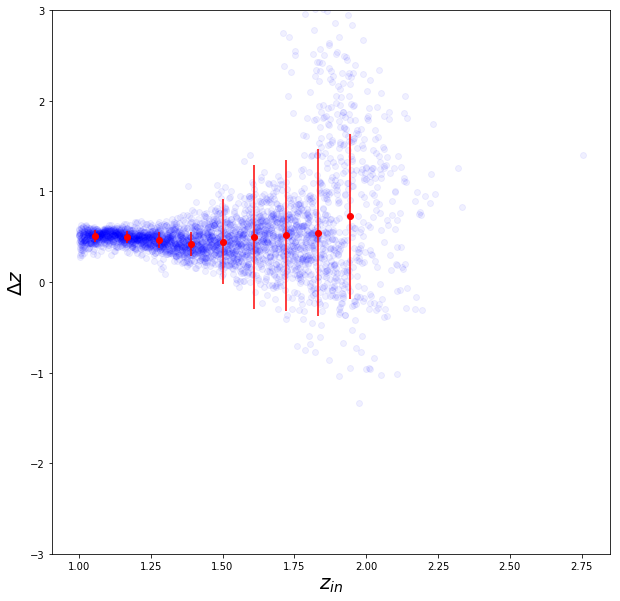

In [25]:
plt.rcParams['figure.figsize'] = [10, 10]

plt.xlabel(r"$z_{in}$",fontsize=20)
plt.ylabel(r"$\Delta z$",fontsize=20)

plt.scatter(zspace_m,zout_m-zspace_m,c="blue",alpha=0.06,label="10000 sims")
plt.errorbar(hb, means, yerr=std,fmt="ro",ecolor="red")
plt.ylim(-3.,3.)
plt.show()

In [26]:
#phot_test = np.array([1.70771e-01,1.91405e+00,5.69421e+00,3.25895e+01,8.45730e+01,1.19146e+02,1.57714e+02])*1e-6
#phot_err_test = np.array([7.44628e-02,3.79339e-02,2.65289e-02,4.55096e-02,5.64738e-01,9.86226e-01,9.14601e-01])*1e-6
#lam_c = np.array([2.9928e+03,4.5573e+03,6.0013e+03,7.9960e+03,1.2289e+04,1.6444e+04,2.2124e+04])*1e-4

In [27]:
#%matplotlib auto

In [28]:
#lam2,Flam2 = np.loadtxt(home + "/eazy-photoz/templates/vb/Arp220_template_norm.sed",unpack=True)
#nuFnu2 = Flam2*lam2
#lam2um = lam2*1e-4
#nu2 = c/(lam2*1e-10)
#Fnu2 = nuFnu2/nu2*1e23*160./6.1e15
#plt.loglog(lam2um,Fnu2,"r-",markersize=0.5)
#plt.xlabel(r"$\lambda [\mu m]$")
#plt.ylabel(r"$F\nu$ $[Jy]$")

#z = 0.0185
#mysed = sed(parfile,tempfile)
#mysed.redshift(z)
#mysed.photometry()

#ax = plt.subplot(111)
#ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')

#plt.errorbar(mysed.lam_c, mysed.phot, xerr=mysed.lam_err, yerr=mysed.phot_err,fmt="bo",ecolor="blue")
#plt.plot(mysed.lam_eff, mysed.phot_c, "ro")
#mysed.plot_sed(scale="normal",color="red")

#plt.show()


In [29]:
print datetime.now() - startTime

0:05:53.251301


In [30]:
#tau_ign = 0.805*((1.+z_L)**3)*((1./(1.+z_L)) - (1./(1+z)) )

In [31]:
#def tau_ign(z):
#    lam = np.linspace(1000.,6000.,1000)
#    lam_L = 912.
#    z_L = lam/lam_L
#    return lam,0.805*((1.+z_L)**3)*((1./(1.+z_L)) - (1./(1.+z)) )

In [32]:
#lam,tau = tau_ign(1.)

In [33]:
#plt.plot(lam,np.exp(tau),"ro")
#plt.show()

In [34]:
#import extinction

In [35]:
#from extinction import calzetti00

In [36]:
#Checking extinction

#z = 1.0
#mysed = sed(parfile,tempfile)
#mysed.redshift(z)

#ax = plt.subplot(111)
#ax.set_xscale("log", nonposx='clip')
#ax.set_yscale("log", nonposy='clip')

#mysed.plot_sed(scale="normal",color="red")
#plt.ylim(1e-10,4e-2)
#plt.xlim(1e-1,5e3)
#mysed = sed(parfile,tempfile)

#extinction
#mysed.extinction()
#mysed.redshift(z)
#mysed.plot_sed(scale="normal",color="blue")

#plt.show()

In [37]:
#mysed.plot_extinction()

In [38]:
#plt.xlabel(r"$\lambda$ $[\mu m]$")
#plt.ylabel(r"Extinction")
#plt.plot(mysed.lam[0:10000],mysed.ext[0:10000])

In [39]:
#mysed.maxval